In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(8,8))

# Import Images

In [7]:
# import images and resize into 250x250
import glob
img_rows, img_cols = 224, 224
import cv2
N = 150
data = np.empty((N, img_rows, img_cols, 3), dtype=np.uint8)#../hackathon/*
img_names = []
for ix, filename in enumerate(glob.glob("../hackathon/car_parking_dataset/*.*")): #/Users/Stav/Downloads/cars_markus_old/*.jpg")): #assuming gif
    try:
        img_names.append(filename)
        img = cv2.imread(filename,flags = 1)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # opencv reads images in bgr lets convert back
        img = cv2.resize(img, (img_rows,img_cols))
        #print (img.shape)
        data[ix, ...] = img#.transpose(2, 0, 1)
    except:
        continue

# Showfig function

In [8]:
#Use the following function when reading an image through OpenCV and displaying through plt.
def showfig(image, ucmap):
    #There is a difference in pixel ordering in OpenCV and Matplotlib.
    #OpenCV follows BGR order, while matplotlib follows RGB order.
    if len(image.shape)==3 :
        b,g,r = cv2.split(image)       # get b,g,r
        #image = cv2.merge([r,g,b])     # switch it to rgb
    imgplot=plt.imshow(image, ucmap)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)

# Process 

In [9]:
def process_image(img):
    
#     carsample = img.copy()
#     gray_carsample = cv2.cvtColor(carsample, cv2.COLOR_BGR2GRAY)
    
#     blur=cv2.GaussianBlur(gray_carsample,(5,5),0)
#     sobelx=cv2.Sobel(blur, cv2.CV_8U, 1, 0, ksize=3)
#     _,th2=cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     se=cv2.getStructuringElement(cv2.MORPH_RECT,(23,2))
#     closing=cv2.morphologyEx(th2, cv2.MORPH_CLOSE, se)
    
    carsample = img.copy()
    gray_carsample = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    noise_removal = cv2.bilateralFilter(gray_carsample,9,75,75)
    equal_histogram = cv2.equalizeHist(noise_removal)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    morph_image = cv2.morphologyEx(equal_histogram,cv2.MORPH_OPEN,kernel,iterations=15)
    
    sub_morp_image = cv2.subtract(equal_histogram,morph_image)
    # Thresholding the image
    ret,thresh_image = cv2.threshold(sub_morp_image,0,255,cv2.THRESH_OTSU)
    
    canny_image = cv2.Canny(thresh_image,250,255)
    
    canny_image = cv2.convertScaleAbs(canny_image)

    # dilation to strengthen the edges
    kernel = np.ones((3,3), np.uint8)
    # Creating the kernel for dilation
    dilated_image = cv2.dilate(canny_image,kernel,iterations=1)
                
        
    _,contours,_=cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        if validate(cnt):
            rect=cv2.minAreaRect(cnt)  
            box=cv2.boxPoints(rect) 
            box=np.int0(box)  
            cv2.drawContours(carsample, [box], 0, (0,0,255),2)
        else:
            rect=cv2.minAreaRect(cnt)  
            box=cv2.boxPoints(rect) 
            box=np.int0(box)  
            cv2.drawContours(carsample, [box], 0, (0,255,0),2)
        
    
    showfig(carsample, None)
    # Finding Contours in the image based on edges

def validate(cnt):    
    rect=cv2.minAreaRect(cnt)  
    box=cv2.boxPoints(rect) 
    box=np.int0(box)  
    output=False
    width=rect[1][0]
    height=rect[1][1]
    if ((width!=0) & (height!=0)):
        if (((height/width>3) & (height>width)) | ((width/height>3) & (width>height))):
            if((height*width<16000) & (height*width>3000)): 
                output=True
    return output


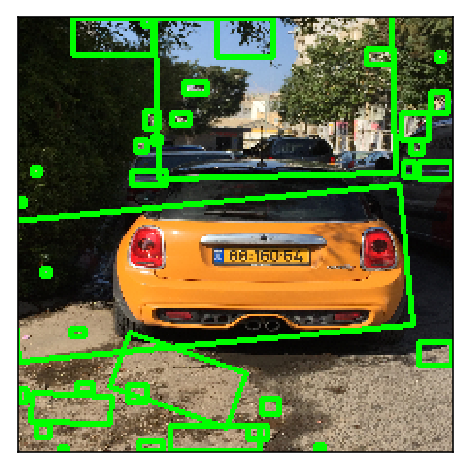

In [15]:
process_image(data[15])
